<a href="https://colab.research.google.com/github/noora20FH/PCVK/blob/main/Leaf_classification_final_PCVK_Noora_Aulia_Hidayat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Importing some useful/necessary packages
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV

from sklearn.metrics import accuracy_score, log_loss

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import cv2

%matplotlib inline

In [4]:
# Read the .csv files as pandas dataframe

train_csv_file = '/content/drive/MyDrive/Leaf_Images/train_dataset/train_dataset.csv'
test_csv_file = '/content/drive/MyDrive/Leaf_Images/test_dataset/test_dataset.csv'

train_raw = pd.read_csv(train_csv_file)
test_raw = pd.read_csv(test_csv_file)

#print type(train_raw), type(test_raw)
print ('There are {}'.format(train_raw.shape[0]), \
       'samples for building the machine learning model and {}'.format(test_raw.shape[0]), \
       'samples for evaluating your model via Kaggle.')

There are 24 samples for building the machine learning model and 6 samples for evaluating your model via Kaggle.


In [5]:
# Let's look at the first 5 rows of train_raw dataset
train_raw.head(5)

,image_name,label
0,1525.jpg,Acer_Capillipes
1,425.jpg,Castanea_Sativa
2,1273.jpg,Castanea_Sativa
3,160.jpg,Acer_Circinatum
4,164.jpg,Acer_Circinatum


#Data Processing

In [8]:
# Preprocess the data to fit for the classifier
le = LabelEncoder().fit(train_raw.label) # Instantiate a LabelEncoder and fit to the given label data
labels = le.transform(train_raw.label)  # encode species strings and return labels with value between 0 and n_classes-1
classes = list(le.classes_)  # Save the species
test_ids = test_raw.image_name  # Save the image ids in test dataset

train = train_raw.drop(['image_name', 'label'], axis=1)
test = test_raw.drop(['image_name'], axis=1)

In [11]:
# Double check the data
print ("The shapes of train and labels are: ", train.shape, labels.shape)
print ("There are {} label in total.".format(len(classes)) )
print ("The shapes of test and test_ids are: ", test.shape, test_ids.shape)

The shapes of train and labels are:  (24, 0) (24,)
There are 3 label in total.
The shapes of test and test_ids are:  (6, 1) (6,)


##Split the 'train' data for cross-validation

In [12]:
# construct the iterator
ss_split = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
ss_split.get_n_splits(train, labels)

for train_index, test_index in ss_split.split(train, labels):
    X_train, X_test = train.values[train_index], train.values[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

Now we have split the 'train' dataset into two parts:
- X_train, y_train
- X_test, y_test

In [14]:
# Double check the data
print (y_train.shape, y_test.shape)

(19,) (5,)


##visualize the images

In [20]:
import matplotlib.pyplot as plt
import cv2
import numpy as np


In [30]:
import os

def leaf_image(image_id, target_length=160):
    """
    `image_id` should be the index of the image in the Leaf_Images/ folder

    Return the image of a given id (1~1584) with the target size (target_length x target_length)
    """

    image_name = str(image_id)
    image_path = os.path.join('/content/drive/MyDrive/Leaf_Images', image_name)

    leaf_img = plt.imread(image_path)  # Reading in the image
    leaf_img_width = leaf_img.shape[1]
    leaf_img_height = leaf_img.shape[0]

    img_target = np.zeros((target_length, target_length), np.uint8)

    if leaf_img_width >= leaf_img_height:
        scale_img_width = target_length
        scale_img_height = int((float(scale_img_width) / leaf_img_width) * leaf_img_height)
        img_scaled = cv2.resize(leaf_img, (scale_img_width, scale_img_height), interpolation=cv2.INTER_AREA)
        copy_location = (target_length - scale_img_height) // 2
        img_target[copy_location:copy_location + scale_img_height, :] = img_scaled
    else:
        scale_img_height = target_length
        scale_img_width = int((float(scale_img_height) / leaf_img_height) * leaf_img_width)
        img_scaled = cv2.resize(leaf_img, (scale_img_width, scale_img_height), interpolation=cv2.INTER_AREA)
        copy_location = (target_length - scale_img_width) // 2
        img_target[:, copy_location:copy_location + scale_img_width] = img_scaled

    return img_target


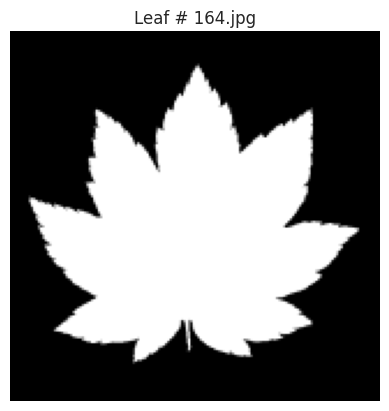

In [37]:


# Test the leaf_image function
leaf_id = '164.jpg'
leaf_img = leaf_image(leaf_id, target_length=160);

plt.imshow(leaf_img, cmap='gray'); plt.title('Leaf # '+ leaf_id); plt.axis('off'); plt.show()

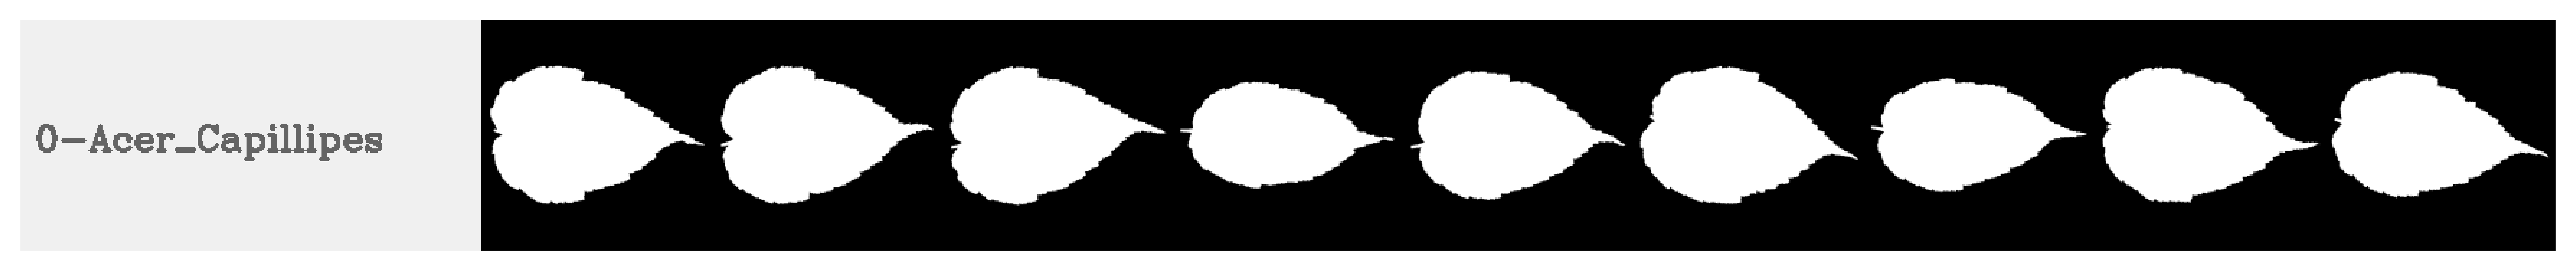

0-Acer_Capillipes


In [43]:
def species_image(species):
    """
    `species` should be the index or species name

    Returns an image of a certain labeled species
    """

    leaf_image_length = 160
    img_target = 240 * np.ones([leaf_image_length, leaf_image_length * 2], np.uint8)  # Initialization
    label_info = ''

    if isinstance(species, int) and 0 <= species < 99:
        images_index = np.where(labels == species)[0]
        label_info = str(species) + '-' + train_raw.label[images_index[0]]
    elif isinstance(species, str) and species in classes:
        images_index = np.where(train_raw.label == species)[0]
        label_info = str(images_index[0]) + '-' + species
    else:
        print('Error: Please input a valid index or species name')
        return

    for image_index in images_index:
        image_id = train_raw.image_name[image_index]
        leaf_img = leaf_image(image_id)
        img_target = np.append(img_target, leaf_img, axis=1)

    cv2.putText(img_target, label_info, (10, 90), cv2.FONT_HERSHEY_COMPLEX, 0.8, (100, 170, 0), 2)

    return img_target, label_info



# Test the function
species_img, label_info = species_image(0)  # Show this species of given index(0~98)
fig = plt.figure(num=None, figsize=(16, 3), dpi=1200, facecolor='w', edgecolor='w',frameon=False,linewidth = 0)
plt.imshow(species_img, cmap='gray'); plt.axis('off'); plt.show()
print (label_info)
#cv2.imwrite('species/'+label_info+'.jpg', species_img)  # Save the species image


# species_img, label_info = species_image('201.jpg')  # show the species of give name
# fig = plt.figure(num=None, figsize=(16, 3), dpi=1200, facecolor='w', edgecolor='w',frameon=False,linewidth = 0)
# plt.imshow(species_img, cmap='gray'); plt.axis('off'); plt.show()

In [46]:
def visualize_error(train_predictions, y_test):
    """
    Review the images where mistakes occur

    """

    error_indices = np.where(train_predictions != y_test)[0]; print ('The error indices: ', error_indices)
    for err_index in error_indices[0:]:
        print ('Error index in the test set: '), err_index

        err_img_index = train_raw.id[test_index[err_index]]

        print ('Ground truth species index: {}'.format(y_test[err_index]))
        print ('Wrong predicting species index: {}'.format(train_predictions[err_index]))


        plt.imshow(leaf_image(err_img_index, 160), cmap='gray'); plt.axis('off'); plt.show()

        wrong_pred_species_img, label_info = species_image(train_predictions[err_index])
        fig = plt.figure(num=None, figsize=(16, 3), dpi=1200, facecolor='w', edgecolor='w',frameon=False,linewidth = 0)
        wrong_pred_species_img = cv2.cvtColor(wrong_pred_species_img,cv2.COLOR_GRAY2RGB)
        wrong_pred_species_img = cv2.copyMakeBorder(wrong_pred_species_img,10,10,10,10,cv2.BORDER_CONSTANT,value=[255,0,0])

        plt.imshow(wrong_pred_species_img, cmap='gray'); plt.axis('off'); plt.show()

        ground_truth_species_img, label_info = species_image(y_test[err_index])
        fig = plt.figure(num=None, figsize=(16, 3), dpi=1200, facecolor='w', edgecolor='w',frameon=False,linewidth = 0)
        plt.imshow(ground_truth_species_img, cmap='gray'); plt.axis('off'); plt.show()

        print ('#'*50)

In [48]:
# List and save all the classes
for i, class_ in enumerate(classes):
    species_img, label_info = species_image(i)  # Show this species of given index(0~98)
    print (label_info)
    cv2.imwrite('species/'+label_info+'.jpg', species_img)

0-Acer_Capillipes
1-Acer_Circinatum
2-Castanea_Sativa


#Machine learning classifiers

##Naive Bayes

In [50]:
clf = GaussianNB().fit(X_train, y_train) # Instantiate a classifier and fit this classifier to the data
print ('ML Model: ', clf.__class__.__name__)

# Cross-validation
scores = cross_val_score(GaussianNB(), train.values, labels, cv=ss_split)
#print 'Mean Cross-validation scores: {}'.format(np.mean(scores))

train_predictions = clf.predict(X_test)
acc = accuracy_score(y_test, train_predictions)
print ('Accuracy: {:.4%}'.format(acc))

train_predictions = clf.predict_proba(X_test)
ll = log_loss(y_test, train_predictions)
print ('Log Loss: {:.6}'.format(ll))

ValueError: ignored